In [3]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
import pywt

In [4]:
alpha = 0.9
n=2**20
#generate processus by using Auto-regressive filter
def generator(n, alpha):
    W=np.random.randn(n)
    a = np.array([1, -alpha])
    b = np.array([1-alpha])
    X = signal.lfilter(b ,a, W)
    return X

In [5]:
X = generator(n, alpha)

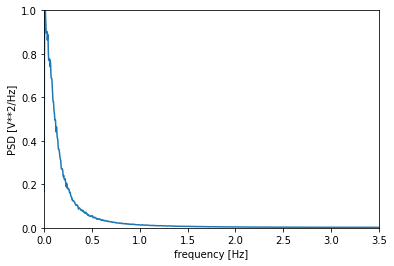

In [6]:
f, Pxx_den = signal.welch(X,fs=7,nperseg=2048)#PSD
Pxx_den/=np.max(Pxx_den)#normalization by maximum
plt.plot(f, Pxx_den)
plt.ylim([0.5e-3, 1])
plt.xlim([0, 3.5])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()

We first generate the random process for further experiments,

it is synthesized by sampling a random process with AR filter.

In [7]:
def AutoCorrelation(x):
    x = np.asarray(x)
    y = x-x.mean()
    result = signal.correlate(y, y, mode='full')# 2n-1 n=nb of points of processus
    result /= result[len(result)//2]           #Normalisation max
    return result 

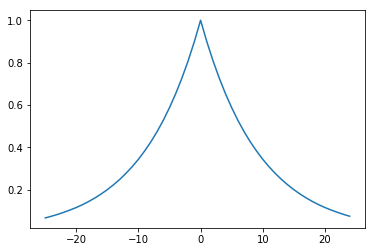

In [8]:
res = AutoCorrelation(X)
semiiBand = 25
t = res[int(n)-semiiBand-1:int(n)+semiiBand-1]# choose 50 around lag0 (t-s)==0
index=range(-25,25,1)
plt.plot(index,t)

We generate the autocorrelation function of the random process above.

The wavelet packet decomposition is produced as follows:

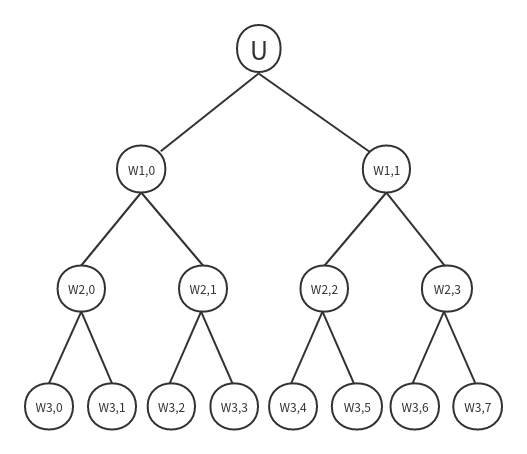

Wavelet Packet Decomposition is a further improvement of wavelet transform. 

The main idea of the algorithm is: on the basis of wavelet transform, in each stage of signal decomposition, in addition to further decomposing the low frequency subband, the high frequency subband is also decomposed. 

Finally, by minimizing a cost function, the optimal signal decomposition path is calculated, and the original signal is decomposed using this decomposition path.

By doing so, we can find a finer decomposition of signals.

We plot the normalised autocorrelation functions of coefficients of the wavelet packet.

The wavelet function that we use in this simulation is Daubechies wavelet, for an order-N Daubechies function, the scale function of the wavelet and the support interval length of the wavelet function are 2N-1. When N=1, the wavelet is equivalent to the Harr wavelet.

In [9]:
Db_1 = 'db1'
Db_7 = 'db7'
wp_1 = pywt.WaveletPacket(data=X, wavelet=Db_1, mode='symmetric') 
wp_7 = pywt.WaveletPacket(data=X, wavelet=Db_7, mode='symmetric')


In [10]:
#the node determinated by convert resolution and k(q)into 'aa..dd..' a:0 d:1 
def convert(j, q):
    if j==0:
        return ''
    if q==0:
        q=0
    else:
        if j<q:
            q=0
        else:
            q = 2**(j-q)
    a = bin(q).split('b')[1]
    res = (j-len(a))*'0'+a
    res = res.replace('0','a')
    res = res.replace('1', 'd')
    return res   

In [11]:
C_760 = wp_7[convert(6,0)].data[0:1500] # 760  7:order of filter  6:level of resolution j   0:k0 (0,0,0,...) 
C_761 = wp_7[convert(6,1)].data[0:1500]
C_762 = wp_7[convert(6,2)].data[0:1500]
C_763 = wp_7[convert(6,3)].data[0:1500]

C_130 = wp_1[convert(3,0)].data[0:1500]
C_131 = wp_1[convert(3,1)].data[0:1500]
C_132 = wp_1[convert(3,2)].data[0:1500]
C_133 = wp_1[convert(3,3)].data[0:1500]

C_160 = wp_1[convert(6,0)].data[0:1500]
C_161 = wp_1[convert(6,1)].data[0:1500]
C_162 = wp_1[convert(6,2)].data[0:1500]
C_163 = wp_1[convert(6,3)].data[0:1500]

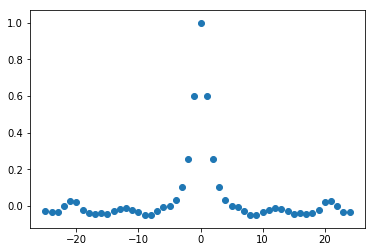

In [12]:
res = AutoCorrelation(C_130)
semiiBand = 25
t = res[int(len(C_130)-1)-semiiBand:int(len(C_130)-1)+semiiBand]
index=range(-25,25,1)
plt.scatter(index,t)

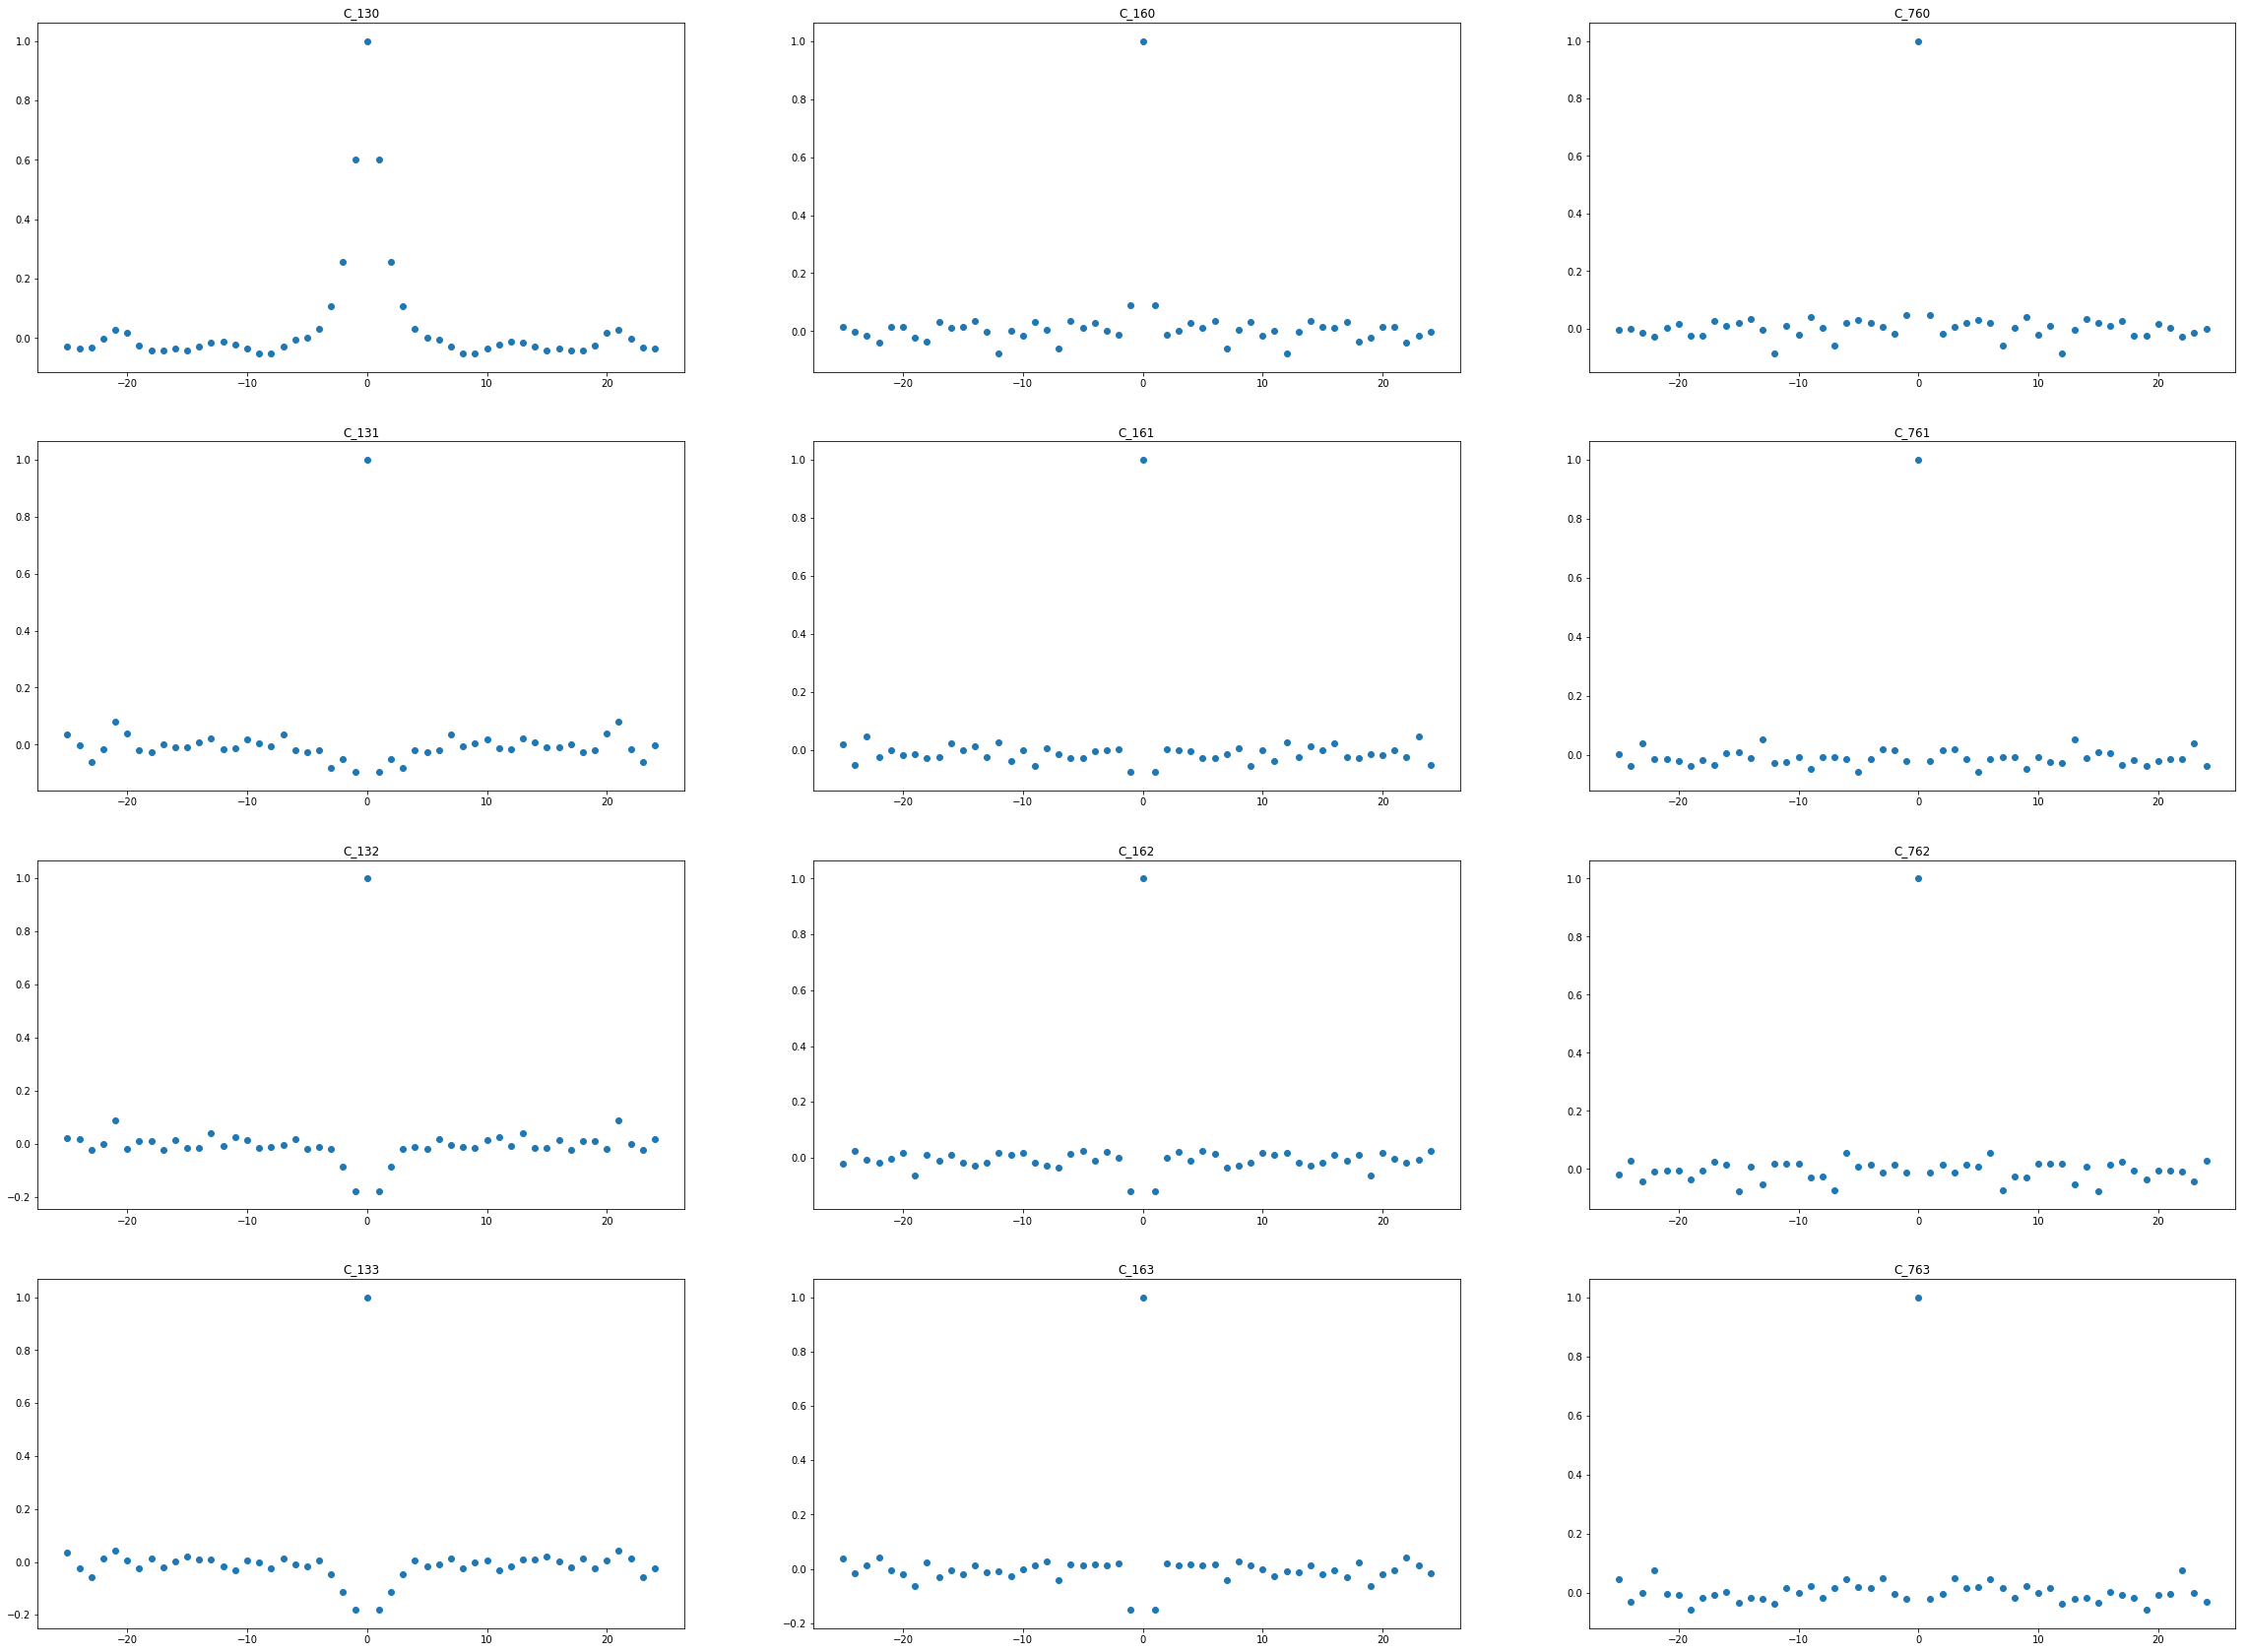

In [14]:
#comparaison of different consequence of different r,j,q 
plotList = [C_130, C_160, C_760, C_131, C_161, C_761, C_132, C_162, C_762, C_133, C_163, C_763]
nameList = ['C_130', 'C_160', 'C_760', 'C_131', 'C_161', 'C_761', 'C_132', 'C_162', 'C_762', 'C_133', 'C_163', 'C_763']
semiiBand = 25
length = 1500
plt.figure(figsize=(4*10,3*10))
for i in range(12):
    plt.subplot(4,3,i+1)
    res = AutoCorrelation(plotList[i])
    t = res[length-1-semiiBand:length-1+semiiBand]
    index=range(-25,25,1)
    plt.scatter(index,t)
    plt.title(nameList[i])


In the above image, the fisrt number denote the order of wavelet ($r$), the second number denote the level of the packet ($j$) and the third number $p$ is used to denote the sequence ($k_p$),which can be used together with $j$ to determinate $n_j$,then ($j$,$n_j$) would be used to locate the position of node studied in the decomposition tree.

We take the first column into consideration, where filter are of the same order (same $r$) and packets are of the same level (same $j$) of decomposition with different positions.
We can note that coefficients of packets at k0 have more correlations.

We take the first and second column into consideration, where filters are of the same order (same $r$) and packets are of different levels of decomposition with same position (same $k_p$). We can note that packets with bigger levels have less correlations.

We take the second and last column into consideration, where filters are of the different orders and packets are of the same level (same $j$) of decomposition and with same position (same $k_p$). We can note that packets using filter with larger order have less correlations.

If we look at the first row, we can note that the autocorrelation function tend to resemble a Shannon filter as the order grows, thus

$\displaystyle\lim_{r\to +\infty} R^{[r]}_{j,n_j}[m] = R^{[S]}_{j,n_j}[m] $

We can note that the autocorrelation function tend to resemble a dirac function as the levels grows, thus

$\displaystyle \lim_{j\to +\infty}(\lim_{r\to +\infty} R^{[r]}_{j,n_j}[m]) = \gamma(a(k))\delta[m] $

In [15]:
def AutoCorrelation_nonnorm(x):
    x = np.asarray(x)
    y = x-x.mean()
    result = signal.correlate(y, y, mode='full')
    return result 

In [16]:
convergenceList = np.zeros((4,10))
#the convergence of R(0) with the change of j(0-9) case r=7 and q=(0,1,2,3) 
for q in range(4):
    for j in range(10):
        coeff = wp_7[convert(j,q)].data[0:1500]
        convergenceList[q][j] = AutoCorrelation_nonnorm(coeff)[1500-1]        

In [17]:
convergenceList/=np.max(convergenceList[0,:])#????

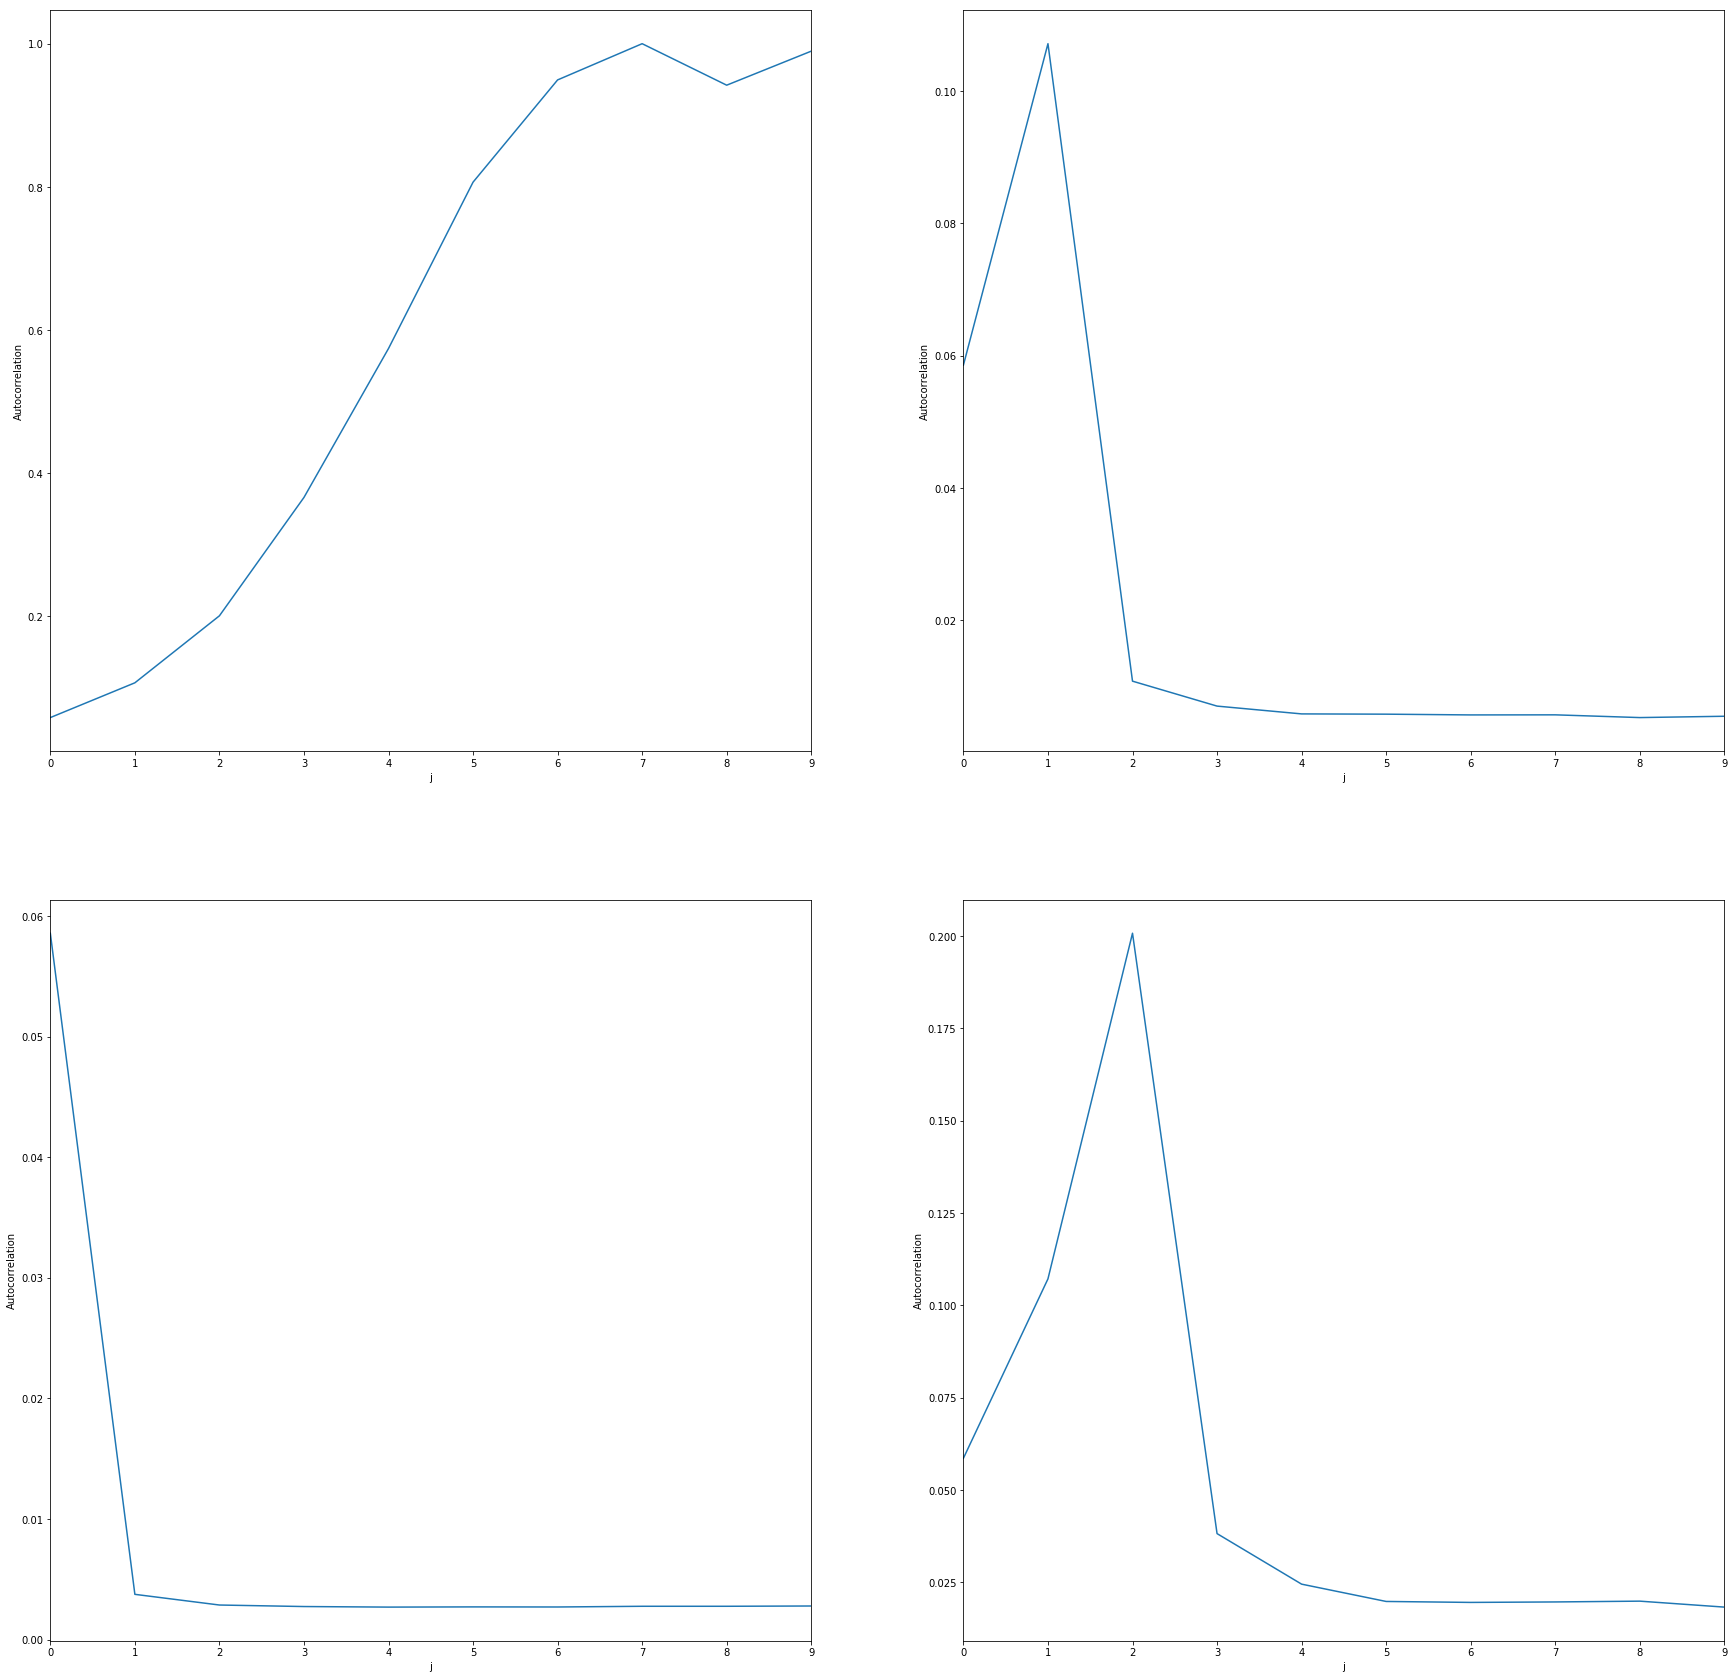

In [19]:
plt.figure(figsize=(2*15,2*15))
index = 1 
for i in [0,2, 1, 3]:
    plt.subplot(2,2,index)
    index+=1
    plt.xlim([0,9])
    plt.plot(convergenceList[i,:])
    plt.xlabel('j')
    plt.ylabel('Autocorrelation')

We look through the convergence of the packets at different positions using order-7 filter, we can see that  the autocorrelation will converge to a certain value depending on the kp.

It proves the theorem 
$\displaystyle \lim_{j\to +\infty}(\lim_{r\to +\infty} R^{[r]}_{j,n_j}[m]) = \gamma(a(k))\delta[m] $
with $\gamma(a(k))$ converge to different values.


#### Reference:
1.Abdourrahmane Atto, Dominique Pastor, Alexandru Isar. On the Statistical Decorrelation of theWavelet Packet Coefficients of a Band-Limited Wide-Sense Stationary Random Process. Signal Pro-cessing, Elsevier, 2007, 87 (10), pp.2320-2335. ￿10.1016/j.sigpro.2007.03.014￿. ￿hal-00732481￿